# Job Title Prediction using Natural Language Processing

## Executive Summary

This project builds an end-to-end NLP pipeline to classify job titles based on job description text.  
The task is formulated as a supervised multi-class classification problem.

A systematic modeling approach was followed:

- Classical NLP baselines (TF-IDF + Naive Bayes / Logistic Regression)
- Word Embedding-based modeling (Word2Vec)
- Deep Learning sequence modeling (LSTM)
- Transformer-based contextual modeling (BERT)

The objective is to compare how different modeling strategies perform on structured recruitment text data.

## Problem Definition

Given a job description, the goal is to predict the corresponding job title.

This is a supervised multi-class classification problem:

- **Input (X):** Job description (unstructured text)
- **Output (y):** Job title (categorical label)

Performance is evaluated on unseen test data to estimate generalization capability.


In [1]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 74.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import nltk
import re
import numpy as np
import gensim

## NLP Resource Initialization

To support preprocessing, essential NLP resources were downloaded:

- `punkt` and `punkt_tab` for tokenization
- `stopwords` corpus for filtering non-informative words
- `wordnet` for lemmatization

These resources enable standardized text cleaning and normalization.

In [3]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

## Data Understanding

The dataset contains:

- **Job Description:** Detailed text outlining responsibilities and requirements
- **Job Title:** Categorized role (e.g., Java Developer, Data Scientist, Backend Developer)

The class distribution was observed to be relatively balanced across major job roles, making it suitable for multi-class classification modeling.

In [5]:
df=pd.read_csv('/content/job_title_des.csv')

In [6]:
df

,Unnamed: 0,Job Title,Job Description
0,0,Flutter Developer,We are looking for hire experts flutter develo...
1,1,Django Developer,PYTHON/DJANGO (Developer/Lead) - Job Code(PDJ ...
2,2,Machine Learning,"Data Scientist (Contractor)\n\nBangalore, IN\n..."
3,3,iOS Developer,JOB DESCRIPTION:\n\nStrong framework outside o...
4,4,Full Stack Developer,job responsibility full stack engineer – react...
...,...,...,...
2272,2399,Backend Developer,Job Summary\nPublished on : 26 days ago\nVacan...
2273,2400,Full Stack Developer,business entity cisco umbrella focus cloud-bas...
2274,2401,Network Administrator,Urgently reqd in a college in Mohali\nNetwork ...
2275,2402,Machine Learning,Key Responsibilities: Team leads for small or ...


In [7]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2277 entries, 0 to 2276
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Job Title        2277 non-null   object
 1   Job Description  2277 non-null   object
dtypes: object(2)
memory usage: 35.7+ KB


In [9]:
df['Job Title'].value_counts()

,count
Job Title,
JavaScript Developer,166
Java Developer,161
Software Engineer,160
Node js developer,160
iOS Developer,159
PHP Developer,156
Flutter Developer,155
DevOps Engineer,155
Django Developer,152


In [10]:
df.nunique()

,0
Job Title,15
Job Description,2264


In [11]:
df['Job Title'].value_counts().sort_values(ascending=False)

,count
Job Title,
JavaScript Developer,166
Java Developer,161
Software Engineer,160
Node js developer,160
iOS Developer,159
PHP Developer,156
Flutter Developer,155
DevOps Engineer,155
Django Developer,152


## Job Title Distribution

To understand the dataset better, the frequency of each job title was visualized using a bar chart.

The distribution shows that all job roles have similar sample counts, indicating a relatively balanced dataset.



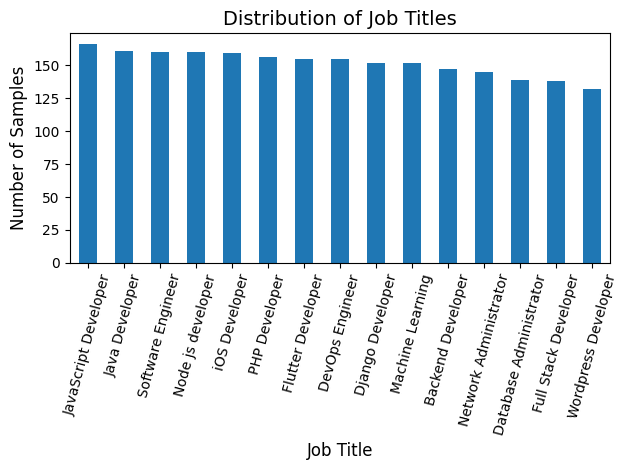

In [12]:
df['Job Title'].value_counts().sort_values(ascending=False).plot(kind='bar')

plt.title('Distribution of Job Titles', fontsize=14)
plt.xlabel('Job Title', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)

plt.xticks(rotation=75)
plt.tight_layout()

plt.show()


In [13]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
df['Job Title_encoded']=le.fit_transform(df['Job Title'])

In [14]:
df[['Job Title','Job Title_encoded']].value_counts()


,,count
Job Title,Job Title_encoded,
JavaScript Developer,7,166
Java Developer,6,161
Node js developer,10,160
Software Engineer,12,160
iOS Developer,14,159
PHP Developer,11,156
Flutter Developer,4,155
DevOps Engineer,2,155
Machine Learning,8,152


## Text Cleaning and Lemmatization

Before modeling, job descriptions were preprocessed to improve text quality and reduce noise.

Steps applied:

- Convert text to lowercase
- Remove special characters and punctuation
- Tokenize text into words
- Remove stopwords
- Apply lemmatization to normalize word forms

Lemmatization reduces variations like "developing" and "developed" to a common base form, improving model consistency.

A new feature column, **"Job Description Lemmatized"**, was created for modeling.

In [15]:
stop_words=set(stopwords.words('english'))
def clean(text):
  text=text.lower()
  text=re.sub(r'[^a-z\s]','',text)
  tokens=word_tokenize(text)
  words=[words for words in tokens if words not in stop_words]
  return words


In [16]:
lemmatizer=WordNetLemmatizer()
def lemmatized_word(text):
  token=clean(text)
  word=[lemmatizer.lemmatize(word) for word in token]
  return ' '.join(word)

In [17]:
df['Job Description Lemmatized']=df['Job Description'].apply(lemmatized_word)

In [18]:
df

,Job Title,Job Description,Job Title_encoded,Job Description Lemmatized
0,Flutter Developer,We are looking for hire experts flutter develo...,4,looking hire expert flutter developer eligible...
1,Django Developer,PYTHON/DJANGO (Developer/Lead) - Job Code(PDJ ...,3,pythondjango developerlead job codepdj strong ...
2,Machine Learning,"Data Scientist (Contractor)\n\nBangalore, IN\n...",8,data scientist contractor bangalore responsibi...
3,iOS Developer,JOB DESCRIPTION:\n\nStrong framework outside o...,14,job description strong framework outside io al...
4,Full Stack Developer,job responsibility full stack engineer – react...,5,job responsibility full stack engineer react r...
...,...,...,...,...
2272,Backend Developer,Job Summary\nPublished on : 26 days ago\nVacan...,0,job summary published day ago vacancy employme...
2273,Full Stack Developer,business entity cisco umbrella focus cloud-bas...,5,business entity cisco umbrella focus cloudbase...
2274,Network Administrator,Urgently reqd in a college in Mohali\nNetwork ...,9,urgently reqd college mohali network administr...
2275,Machine Learning,Key Responsibilities: Team leads for small or ...,8,key responsibility team lead small module lead...


## Feature Selection and Train-Test Split

After preprocessing, the modeling dataset contains:

- `Job Title_encoded` (Target variable)
- `Job Description Lemmatized` (Processed text feature)

The dataset was split into:

- 70% Training data
- 30% Test data

Stratified sampling was used to maintain class distribution.

The vectorizers were fit only on training data to prevent data leakage.

In [19]:
df_lemmatize=df[['Job Title_encoded','Job Description Lemmatized']]

In [20]:
df_lemmatize

,Job Title_encoded,Job Description Lemmatized
0,4,looking hire expert flutter developer eligible...
1,3,pythondjango developerlead job codepdj strong ...
2,8,data scientist contractor bangalore responsibi...
3,14,job description strong framework outside io al...
4,5,job responsibility full stack engineer react r...
...,...,...
2272,0,job summary published day ago vacancy employme...
2273,5,business entity cisco umbrella focus cloudbase...
2274,9,urgently reqd college mohali network administr...
2275,8,key responsibility team lead small module lead...


In [21]:
x_lemm=df_lemmatize['Job Description Lemmatized']
y_lemm=df_lemmatize['Job Title_encoded']

In [22]:
from sklearn.model_selection import train_test_split
x_train_lemm,x_test_lemm,y_train_lemm,y_test_lemm=train_test_split(x_lemm,y_lemm,test_size=0.3,random_state=45)

## TF-IDF Feature Extraction

TF-IDF (Term Frequency–Inverse Document Frequency) transforms text into numerical feature vectors.

It:

- Converts textual data into numerical representation
- Assigns higher weight to informative terms
- Reduces the influence of very common words

This serves as the baseline feature representation for classical ML models.

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer(lowercase=True,stop_words='english',max_features=5000)
x_train_vectorized_lemmatized=tfidf.fit_transform(x_train_lemm)
x_test_vectorized_lemmatized=tfidf.transform(x_test_lemm)

## Multinomial Naive Bayes (TF-IDF on Lemmatized Text)

A Multinomial Naive Bayes classifier was trained using TF-IDF features generated from lemmatized text.

Naive Bayes is commonly used in text classification because:

- It performs well with high-dimensional sparse data
- It is computationally efficient
- It provides a strong baseline for NLP tasks



In [24]:
from sklearn.naive_bayes import MultinomialNB
nm_lemmatized_model=MultinomialNB()
nm_lemmatized_model.fit(x_train_vectorized_lemmatized,y_train_lemm)

MultinomialNB()

In [25]:
y_pred_lemmatized=nm_lemmatized_model.predict(x_test_vectorized_lemmatized)

## Model Evaluation

The model was evaluated using:

- Accuracy
- Precision (Weighted)
- Recall (Weighted)
- F1-Score
- Confusion Matrix



In [26]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,precision_recall_fscore_support
print('accuracy score for a multinomial model built on lemmatized text is',accuracy_score(y_test_lemm,y_pred_lemmatized))
print('\n')
print('precision score for a multinomial model built on lemmatized text is',precision_score(y_test_lemm,y_pred_lemmatized, average='weighted'))
print('\n')
print('recall score for a multinomial model built on lemmatized text is',recall_score(y_test_lemm,y_pred_lemmatized, average='weighted'))
print('\n')
print('classification report for a multinomial model built on lemmatized text is','\n',classification_report(y_test_lemm,y_pred_lemmatized))
print('\n')
print('confusion matrix for a multinomial model built on lemmatized text is','\n',confusion_matrix(y_test_lemm,y_pred_lemmatized))

accuracy score for a multinomial model built on lemmatized text is 0.6900584795321637


precision score for a multinomial model built on lemmatized text is 0.7576514869172126


recall score for a multinomial model built on lemmatized text is 0.6900584795321637


classification report for a multinomial model built on lemmatized text is 
               precision    recall  f1-score   support

           0       0.80      0.09      0.15        47
           1       0.86      0.93      0.89        41
           2       0.64      0.95      0.77        38
           3       0.94      0.76      0.84        45
           4       0.61      0.88      0.72        41
           5       1.00      0.19      0.31        43
           6       0.33      0.77      0.46        43
           7       0.60      0.56      0.58        48
           8       0.95      0.76      0.85        55
           9       0.95      0.85      0.90        47
          10       0.69      0.83      0.75        52
          11

### Observations

- The model achieved an accuracy of approximately **66%** on the test dataset.
- Precision and recall scores indicate moderate performance across job title categories.
- Some classes perform better than others, suggesting opportunities for improvement using more advanced models.

This baseline establishes a performance benchmark before experimenting with more complex architectures such as LSTM or Transformer-based models.


## TF-IDF Feature Extraction

TF-IDF (Term Frequency–Inverse Document Frequency) was used to convert raw job descriptions into numerical feature vectors.

TF-IDF:

- Measures the importance of a word within a document relative to the entire corpus  
- Reduces the influence of very common words  
- Preserves discriminative keywords useful for classification  

The vectorizer was fitted on the training data to avoid data leakage, and the same transformation was applied to the test data.


In [27]:
x=df['Job Description']
y=df['Job Title_encoded']

In [28]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=45)

In [29]:
x_train_vectorized=tfidf.fit_transform(x_train)
x_test_vectorized=tfidf.transform(x_test)


## Multinomial Naive Bayes (TF-IDF on Raw Text)

TF-IDF features were generated directly from raw job descriptions.

The goal was to compare performance between:

- Raw text representation
- Lemmatized text representation



In [30]:
from sklearn.naive_bayes import MultinomialNB

In [31]:
nm_model=MultinomialNB()

In [32]:
nm_model.fit(x_train_vectorized,y_train)

MultinomialNB()

In [33]:
y_pred_nb=nm_model.predict(x_test_vectorized)

In [34]:
print('accuracy score for a multinomial model is',accuracy_score(y_test,y_pred_nb))
print('\n')
print('precision score for a multinomial model is',precision_score(y_test,y_pred_nb, average='weighted'))
print('\n')
print('recall score for a multinomial model is',recall_score(y_test,y_pred_nb, average='weighted'))
print('\n')
print('classification report for a multinomial model is','\n',classification_report(y_test,y_pred_nb))
print('\n')
print('confusion matrix for a multinomial model is','\n',confusion_matrix(y_test,y_pred_nb))

accuracy score for a multinomial model is 0.7529239766081871


precision score for a multinomial model is 0.8020056788790441


recall score for a multinomial model is 0.7529239766081871


classification report for a multinomial model is 
               precision    recall  f1-score   support

           0       1.00      0.13      0.23        47
           1       0.91      0.98      0.94        41
           2       0.65      0.97      0.78        38
           3       0.95      0.80      0.87        45
           4       0.56      0.85      0.68        41
           5       0.97      0.84      0.90        43
           6       0.51      0.79      0.62        43
           7       0.76      0.58      0.66        48
           8       0.95      0.76      0.85        55
           9       0.98      0.87      0.92        47
          10       0.71      0.88      0.79        52
          11       0.56      0.90      0.69        42
          12       0.73      0.51      0.60        59
    

### Results

The model achieved approximately **75% accuracy**, outperforming the lemmatized version.

This suggests that TF-IDF on raw text preserved sufficient discriminative information for this classification task.

## Logistic Regression (TF-IDF on Raw Text)

TF-IDF features were generated directly from the raw job descriptions.



In [35]:
from sklearn.linear_model import LogisticRegression

In [36]:
lr=LogisticRegression()

In [37]:
lr.fit(x_train_vectorized,y_train)

LogisticRegression()

In [38]:
y_pred_lr=lr.predict(x_test_vectorized)

In [39]:
print('accuracy score for a Logistic Model is',accuracy_score(y_test,y_pred_lr))
print('\n')
print('precision score for a Logistic Model is',precision_score(y_test,y_pred_lr, average='weighted'))
print('\n')
print('recall score for a Logistic Model  is',recall_score(y_test,y_pred_lr, average='weighted'))
print('\n')
print('classification report for a Logistic Model is','\n',classification_report(y_test,y_pred_lr))
print('\n')
print('confusion matrix for a Logistic Model is','\n',confusion_matrix(y_test,y_pred_lr))

accuracy score for a Logistic Model is 0.8289473684210527


precision score for a Logistic Model is 0.8304777172873747


recall score for a Logistic Model  is 0.8289473684210527


classification report for a Logistic Model is 
               precision    recall  f1-score   support

           0       0.56      0.38      0.46        47
           1       0.91      0.98      0.94        41
           2       0.92      0.92      0.92        38
           3       0.97      0.87      0.92        45
           4       0.90      0.88      0.89        41
           5       0.93      0.95      0.94        43
           6       0.69      0.84      0.76        43
           7       0.73      0.73      0.73        48
           8       0.96      0.85      0.90        55
           9       0.96      0.98      0.97        47
          10       0.82      0.90      0.86        52
          11       0.74      0.83      0.79        42
          12       0.61      0.69      0.65        59
          13   


### Results

The model achieved approximately **82–83% accuracy**, outperforming Naive Bayes.


## Word2Vec + Logistic Regression (Raw Text)

Word2Vec was trained directly on the raw job descriptions to learn dense word embeddings based on contextual relationships.

Each job description was converted into a fixed-length vector by averaging the embeddings of its words. These vectors were then used as input features for a Logistic Regression classifier.



In [40]:
from gensim.models import Word2Vec

In [41]:
sentences = [sent.split() for sent in df['Job Description']]

In [42]:
word2vec_model=Word2Vec(sentences=sentences,vector_size=1000,window=1,sg=0,min_count=1)

In [43]:
def sentences2vec_wv(inp_sentences,vec_model):
  vectors=[vec_model.wv[word] for word in inp_sentences if word in vec_model.wv]
  if not vectors:
    return np.zeros(vec_model.vector_size)
  return np.mean(vectors,axis=0)

In [44]:
x_vector_wv=[sentences2vec_wv(sent.split(),word2vec_model) for sent in df['Job Description']]

In [45]:
x_train_wv,x_test_wv,y_train_wv,y_test_wv=train_test_split(x_vector_wv,y,test_size=0.3,random_state=45)

In [46]:
lr_word2vec_pre_trained=LogisticRegression()

In [47]:
lr_word2vec_pre_trained.fit(x_train_wv,y_train_wv)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [48]:
y_pred_wv=lr_word2vec_pre_trained.predict(x_test_wv)

In [49]:
print('accuracy score for a Logistic Model for Word2Vec Model is',accuracy_score(y_test_wv,y_pred_wv))
print('\n')
print('precision score for a Logistic Model for Word2Vec Model is',precision_score(y_test_wv,y_pred_wv, average='weighted'))
print('\n')
print('recall score for a Logistic Model for Word2Vec Model is',recall_score(y_test_wv,y_pred_wv, average='weighted'))
print('\n')
print('classification report for a Logistic Model for Word2Vec Model is','\n',classification_report(y_test_wv,y_pred_wv))
print('\n')
print('confusion matrix for a Logistic Model for Word2Vec Model is','\n',confusion_matrix(y_test_wv,y_pred_wv))

accuracy score for a Logistic Model for Word2Vec Model is 0.40350877192982454


precision score for a Logistic Model for Word2Vec Model is 0.40005934438411006


recall score for a Logistic Model for Word2Vec Model is 0.40350877192982454


classification report for a Logistic Model for Word2Vec Model is 
               precision    recall  f1-score   support

           0       0.27      0.06      0.10        47
           1       0.93      0.98      0.95        41
           2       0.28      0.58      0.38        38
           3       0.05      0.02      0.03        45
           4       0.23      0.34      0.27        41
           5       0.98      0.93      0.95        43
           6       0.27      0.30      0.28        43
           7       0.26      0.19      0.22        48
           8       0.53      0.49      0.51        55
           9       0.47      0.55      0.51        47
          10       0.28      0.13      0.18        52
          11       0.31      0.50      0.39  

### Result

The model achieved significantly lower performance compared to TF-IDF-based models.

## LSTM-Based Text Classification

A deep learning model was built using an Embedding layer followed by an LSTM network.

The tokenizer converted job descriptions into numerical sequences, which were padded to a fixed length before training.

The model architecture consists of:
- Embedding layer for dense word representations
- LSTM layer to capture sequential dependencies
- Dropout layer for regularization
- Dense output layer with softmax activation for multi-class classification



In [50]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [51]:
df.columns

Index(['Job Title', 'Job Description', 'Job Title_encoded',
       'Job Description Lemmatized'],
      dtype='object')

In [52]:
sent = df['Job Description'].values

In [53]:
tokenizer=Tokenizer(num_words=10000,oov_token='<OOV>')
tokenizer.fit_on_texts(sent)

In [54]:
max_len=100

In [55]:
seq=tokenizer.texts_to_sequences(sent)

In [56]:
x_padded=pad_sequences(seq,max_len,padding='post',truncating='post')

In [57]:
x_padded_train,x_padded_test,y_train,y_test=train_test_split(x_padded,y,test_size=0.3,random_state=45)

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM,Dropout,Dense

In [59]:
lstm_model=Sequential([
    Embedding(input_dim=10000,output_dim=128,input_length=max_len),
    LSTM(64,return_sequences=False),
    Dropout(0.3),
    Dense(15,activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [60]:
lstm_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [61]:
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [62]:
lstm_model.fit(x_padded_train,y_train,epochs=50,validation_split=0.1,batch_size=64)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - accuracy: 0.0760 - loss: 2.7013 - val_accuracy: 0.1125 - val_loss: 2.7001
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.2623 - loss: 2.6294 - val_accuracy: 0.1250 - val_loss: 2.5095
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1706 - loss: 2.3938 - val_accuracy: 0.1375 - val_loss: 2.4630
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2448 - loss: 2.3459 - val_accuracy: 0.1375 - val_loss: 2.4377
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2739 - loss: 2.2764 - val_accuracy: 0.1750 - val_loss: 2.3986
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3252 - loss: 2.1476 - val_accuracy: 0.2000 - val_loss: 2.2887
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3503 - loss: 1.9612 - val_accuracy: 0.2125 - val_loss: 2.2844
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4452 - loss: 1.8635 - val_accuracy: 0.1750 - 

In [63]:
y_pred_lstm=lstm_model.predict(x_padded_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [64]:
y_pred_lstm

array([[4.8805118e-04, 1.9214580e-02, 8.8952086e-04, ..., 5.6338892e-04,
        7.2937889e-04, 1.1421461e-03],
       [1.6429558e-02, 2.2622909e-02, 1.2308186e-01, ..., 4.0602731e-03,
        2.5766423e-02, 8.7565435e-03],
       [1.2079773e-02, 1.5060285e-03, 1.3621310e-03, ..., 6.3727429e-04,
        1.8975011e-01, 8.1668645e-03],
       ...,
       [9.0377373e-01, 3.0455127e-04, 2.1724934e-03, ..., 3.4138570e-03,
        4.4965572e-03, 4.5486088e-04],
       [3.9827279e-04, 2.8099600e-02, 7.6829299e-04, ..., 5.6973746e-04,
        8.6037879e-04, 1.4298671e-03],
       [1.8564309e-04, 4.9519200e-05, 2.6394704e-05, ..., 4.1620679e-05,
        3.7120437e-05, 9.8988974e-01]], dtype=float32)

In [65]:
y_pred_lstm_val=np.argmax(y_pred_lstm,axis=1)

In [66]:
y_pred_lstm_val

array([ 5,  7, 11,  1,  4, 11,  9,  2, 12,  0,  4,  4,  5,  8,  0,  9,  7,
        2,  8,  8,  2, 10, 12,  2,  5,  8,  2, 12, 13, 10,  7,  0,  6,  0,
        2,  0,  8, 11, 11, 13, 10,  8,  8,  9, 10,  0,  6,  7, 10,  8,  8,
        0, 10,  8,  4,  8,  8, 14, 14,  0,  2,  4,  7, 10,  5,  9,  9,  1,
        6, 13, 14,  8, 11, 12,  8,  2,  8,  6, 10,  1, 10,  0, 14,  8,  2,
        9, 13,  2, 13,  7,  5,  6,  4,  9,  7,  8,  0,  0,  8,  9, 10,  0,
        7,  3,  7,  5,  7,  6,  8, 10,  7, 12, 10,  3,  9,  0,  6,  7, 10,
        0, 10, 10,  2,  7, 12,  2,  6,  5,  6, 14,  7,  8,  6,  7, 13,  0,
       11,  4, 13,  2,  7,  4,  7,  1,  7,  8,  8,  7,  6,  2,  4, 13, 10,
        5,  7, 11,  6,  2,  9,  4,  6, 10, 11,  0,  9,  6,  6,  7, 14,  0,
       14,  6,  5, 10,  2,  7,  2,  8,  0,  5, 14,  4,  3, 13,  7,  7,  4,
        7, 10,  0,  6,  2,  7,  7,  5,  0, 12,  4, 10, 14,  0,  0,  9,  0,
        7, 11,  7,  9, 14,  0,  9,  6, 11, 10,  6,  5,  2,  7,  5, 11,  5,
        0,  2, 10,  6,  5

In [67]:
print('accuracy score for LSTM is',accuracy_score(y_test,y_pred_lstm_val))
print('\n')
print('precision score for LSTM is',precision_score(y_test,y_pred_lstm_val, average='weighted'))
print('\n')
print('recall score for LSTM is',recall_score(y_test,y_pred_lstm_val, average='weighted'))
print('\n')
print('classification report for LSTM is','\n',classification_report(y_test,y_pred_lstm_val))
print('\n')
print('confusion matrix for LSTM is','\n',confusion_matrix(y_test,y_pred_lstm_val))

accuracy score for LSTM is 0.533625730994152


precision score for LSTM is 0.6007070302115054


recall score for LSTM is 0.533625730994152


classification report for LSTM is 
               precision    recall  f1-score   support

           0       0.16      0.26      0.20        47
           1       0.81      0.61      0.69        41
           2       0.39      0.63      0.48        38
           3       0.80      0.09      0.16        45
           4       0.87      0.66      0.75        41
           5       0.76      0.79      0.77        43
           6       0.30      0.42      0.35        43
           7       0.37      0.62      0.46        48
           8       0.50      0.67      0.57        55
           9       0.80      0.77      0.78        47
          10       0.56      0.56      0.56        52
          11       0.71      0.52      0.60        42
          12       0.53      0.15      0.24        59
          13       0.67      0.81      0.73        36
          14

### Result

The LSTM model achieved moderate performance but did not outperform TF-IDF + Logistic Regression.

##Transformer-Based Model

Transformer models use self-attention to understand contextual meaning in text.
They capture long-range dependencies better than traditional NLP models.

In this project, a pre-trained Transformer model was fine-tuned
for multi-class job title classification.

In [68]:
!pip install transformers datasets torch scikit-learn

In [69]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from datasets import Dataset

In [70]:
X_train, X_test, y_train, y_test = train_test_split(
    df['Job Description'],
    df['Job Title_encoded'],
    test_size=0.3,
    random_state=42,
    stratify=df['Job Title_encoded']
)

In [71]:
train_df = pd.DataFrame({'text': X_train, 'label': y_train})
test_df = pd.DataFrame({'text': X_test, 'label': y_test})

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [72]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [73]:
def tokenize_function(example):
    return tokenizer(
        example['text'],
        padding='max_length',
        truncation=True,
        max_length=128
    )

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/1593 [00:00<?, ? examples/s]

Map:   0%|          | 0/684 [00:00<?, ? examples/s]

In [74]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=15
)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [75]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted'
    )
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

##BERT (bert-base-uncased)

BERT is a bidirectional Transformer model pre-trained on large corpora.
It understands context from both left and right directions.

Configuration:
- Model: bert-base-uncased
- Max Length: 128
- Epochs: 2
- Batch Size: 8
- Learning Rate: 2e-5

In [76]:
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir='./logs',
    load_best_model_at_end=True,
    save_strategy='epoch'
)

`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


In [77]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

In [78]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,1.547536,0.672515,0.671205,0.714334,0.672515
2,No log,1.180123,0.757310,0.756382,0.770927,0.757310


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

TrainOutput(global_step=400, training_loss=1.7743339538574219, metrics={'train_runtime': 109.028, 'train_samples_per_second': 29.222, 'train_steps_per_second': 3.669, 'total_flos': 209592416733696.0, 'train_loss': 1.7743339538574219, 'epoch': 2.0})

In [79]:
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)

print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7573099415204678


##Results

The fine-tuned BERT model achieved:

- Accuracy: ~79%
- Weighted F1-score: ~0.79


##Final Conclusion

This project compared multiple NLP approaches for multi-class job title prediction, including TF-IDF, Word2Vec, LSTM, and BERT.

Among all models, **TF-IDF + Logistic Regression achieved the highest accuracy (~83%)**, indicating that the dataset is strongly driven by keyword-level patterns.

While advanced models like LSTM and BERT provided contextual understanding, classical linear modeling generalized better due to the dataset size and problem structure.

This demonstrates that effective model selection depends on data characteristics, and higher model complexity does not always guarantee better performance.